In [43]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from pandas import read_csv
import string
import xml.etree.ElementTree as et
import re
from collections import Counter
import helper_functions 
import collections

# Georgia 2020 U.S. House Election Results

## Election Results Documentation:

Election results from the Georgia Secretary of State Elections Division (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results). Presidential recount results from the Georgia Secretary of State Elections Division via Reuters.

## Shapefile Source Documentation:

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  
Cobb, DeKalb, and Gwinnett counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program.  
Forsyth and Fulton use shapefiles sourced from the respective counties.

## Shapefile Modifications Documentation:

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election.

Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary  
Bartow: Split Cassville/Hamilton Crossing  
Candler: Merge Candler/Metter as Jack Strickland Comm Center  
Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C  
Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile  
Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5   
Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B  
Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps  
Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre  
Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035  
DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits   
Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G  
Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU  
Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits  
Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019  
Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman  
Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps  
Towns: Merge Macedonia/Tate City  
Wilkes: Align 1/2A boundary with the voter file    
Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

## Candidate List

- GCON01DGRI                      Joyce Marie Griggs (Dem)
- GCON01RCAR            Earl L. ""Buddy"" Carter (I) (Rep)
- GCON02DBIS                      Sanford Bishop (I) (Dem)
- GCON02RCOL                                Don Cole (Rep)
- GCON03DALM                            Val Almonord (Dem)
- GCON03RFER                       Drew Ferguson (I) (Rep)
- GCON04DJOH      Henry C. ""Hank"" Johnson, Jr. (I) (Dem)
- GCON04REZA                  Johsie Cruz Ezammudeen (Rep)
- GCON05DWIL                         Nikema Williams (Dem)
- GCON05RSTA                     Angela Stanton-King (Rep)
- GCON06DMCB                         Lucy McBath (I) (Dem)
- GCON06RHAN                            Karen Handel (Rep)
- GCON07DBOU                       Carolyn Bourdeaux (Dem)
- GCON07RMCC                          Rich McCormick (Rep)
- GCON08DHOL                        Lindsay Holliday (Dem)
- GCON08RSCO                        Austin Scott (I) (Rep)
- GCON09DPAN                             Devin Pandy (Dem)
- GCON09RCLY                            Andrew Clyde (Rep)
- GCON10DJOH                   Tabitha Johnson-Green (Dem)
- GCON10RHIC                           Jody Hice (I) (Rep)
- GCON11DBAR                            Dana Barrett (Dem)
- GCON11RLOU                    Barry Loudermilk (I) (Rep)
- GCON12DJOH                             Liz Johnson (Dem)
- GCON12RALL                       Rick W. Allen (I) (Rep)
- GCON13DSCO                         David Scott (I) (Dem)
- GCON13RHIT                          Becky E. Hites (Rep)
- GCON14DAUS                        Kevin Van Ausdal (Dem)
- GCON14RGRE                  Marjorie Taylor Greene (Rep) 

## Election Results Processing

### Load the modified VEST file

Note: This is the modified version of the file created in the statewide notebook

In [44]:
vest_ga_20 = gp.read_file("./raw-from-source/VEST/cleaned_ga_2020/cleaned_ga_2020.shp")
print(vest_ga_20.shape)

(2678, 50)


In [45]:
# Take a look
vest_ga_20.head(1)

#Create a list of the race columns
data_columns = [i for i in vest_ga_20.columns if (("20" in i) | ("21" in i))]
print(data_columns)

['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER', 'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA', 'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC', 'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN', 'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR', 'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL', 'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS', 'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA']


### 1. Load General Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [46]:
loaded_counties = os.listdir("./raw-from-source/Non_Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Non_Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
ga_election = pd.DataFrame(z,columns=dfcols)

#Sanity check that there are the right number of counties
print(len(ga_election["county"].unique()))

159


### Update Race Names

In [47]:
race_name_change_dict = {
    'US House Dist 4/Distrito del Congreso 4':'US House District 4',
    'US House Dist 7/Distrito del Congreso 7':'US House District 7',
    'US House Dist 10/Distrito del Congreso 10':'US House District 10',
}

ga_election["contest"] = ga_election["contest"].map(race_name_change_dict).fillna(ga_election["contest"])

In [48]:
us_house_races = ['US House District 2',
 'US House District 1',
 'US House District 8',
 'US House District 10',
 'US House District 12',
 'US House District 9',
 'US House District 3',
 'US House District 13',
 'US House District 14',
 'US House District 4',
 'US House District 5',
 'US House District 6',
 'US House District 11',
 'US House District 7']

### Filter Down to Relevant Races

In [49]:
ga_election = ga_election[ga_election["contest"].isin(us_house_races)]
ga_election.reset_index(inplace=True,drop=True)

### Clean and Pivot Data

In [50]:
#Make sure votes are integers
ga_election["num_votes"] = ga_election["num_votes"].astype(int)

In [51]:
#Define two function to add the party and district
def get_party(x):
    if "(" in x:
        return x[len(x)-4:len(x)-1].upper()
    else:
        raise ValueError
        
def district_assigner(x):
    if "District" in x:
        return x.split( )[len(x.split( ))-1].zfill(2)
    else:
        raise ValueError

In [52]:
func = np.vectorize(get_party)
party = func(ga_election["choice"])
ga_election["party"] = party

func = np.vectorize(district_assigner)
district = func(ga_election["contest"])
ga_election["DISTRICT"] = district

In [53]:
def get_name(full_name):
    if full_name == 'Henry C. ""Hank"" Johnson, Jr.':
        #print(full_name + " - "+"JOH")
        return "JOH"
    else:
        last_name = full_name.split(" ")[-1]
        last_name = last_name.upper()
        return last_name[0:3]
        #print(full_name + " - "+last_name[0:3])

In [54]:
# Add in the 3 letter candidate name
ga_election["cand"] = ga_election["choice"].apply(lambda x:x.split(" (")[0])
ga_election["cand_abbrev"] =  ga_election["cand"].apply(lambda x: get_name(x))

#### Add a FIPS Column

In [55]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
ga_election['county_fips'] = ga_election['county'].map(fips_dict).fillna(ga_election['county'])
ga_election['county_fips'] = ga_election['county_fips'].astype(str)
ga_election['county_fips'] = ga_election['county_fips'].str.zfill(3)

#### Define the columns needed for the pivot

In [56]:
ga_election["mod_choice"]="GCON"+ga_election["DISTRICT"]+ga_election["party"].str[0]+ga_election["cand_abbrev"]
ga_election["unique_ID"]=ga_election["county_fips"]+ga_election["precinct"]

#### Create a Fields Dict

In [57]:
fields_dict_cong = dict(zip(ga_election["mod_choice"],ga_election["choice"]))
od = collections.OrderedDict(sorted(fields_dict_cong.items()))
fields_dict_cong_df = pd.DataFrame.from_dict(od, orient ='index')
fields_dict_cong_df.reset_index(inplace = True, drop = False)
fields_dict_cong_df.columns = ['Field_Name', 'Cand_Name']
fields_dict_cong_df.to_csv("./cand_dicts/congressional_fields_dict.csv", index = False)

#### Pivot the DataFrame

In [58]:
ga_election=pd.pivot_table(ga_election,index=["unique_ID","county","county_fips","precinct"],columns=["mod_choice"],values=['num_votes'],aggfunc=sum)
ga_election = ga_election.fillna(0)
ga_election.columns = ga_election.columns.droplevel(0)
ga_election = ga_election.reset_index()

### Combine Northgate Assembly and Trinity in Election Results

Note: We perfomed this in the modified version of the VEST file as well. This corrects an issue with votes appearing in a precinct outside of a congressional district. Please see the main file README for more information

In [59]:
to_remove = ga_election[(ga_election["county"]=="Lowndes") & (ga_election["precinct"].isin(["Northgate Assembly", "Trinity"]))]
remaining_elections = ga_election[~((ga_election["county"]=="Lowndes") & (ga_election["precinct"].isin(["Northgate Assembly", "Trinity"])))]

In [60]:
# Print statements to make sure all precincts are counted correctly
print(ga_election.shape)
print(remaining_elections.shape)
print(to_remove.shape)

(2656, 32)
(2654, 32)
(2, 32)


In [61]:
# Combine the two precincts and clean the indices
grouped_to_remove = to_remove.groupby(["county_fips"]).sum()
grouped_to_remove.reset_index(inplace = True, drop = False)

# Add appropriate data columns and filter down to needed columns
grouped_to_remove["unique_ID"] = "185-NORTHGATE ASSEMBLY AND TRINITY"
grouped_to_remove["county"] = 'Lowndes'
grouped_to_remove["county_fips"] = '185' 
grouped_to_remove["precinct"] = 'NORTHGATE ASSEMBLY AND TRINITY'
grouped_to_remove = grouped_to_remove[list(to_remove.columns)]

# Combine the precincts back together
ga_election = pd.concat([remaining_elections, grouped_to_remove])
ga_election.reset_index(inplace = True, drop = True)

## Join Election Results to VEST

In [62]:
ga_cong_districts = gp.read_file("./raw-from-source/US_House_Shapefile/ga_cong_2011_to_2021/ga_cong_2011_to_2021.shp")
ga_cong_districts = ga_cong_districts.to_crs(vest_ga_20.crs)
ga_cong_districts.rename(columns={'DISTRICT':"HOUSE_DISTRICT"},inplace=True)
ga_cong_districts["geometry"] = ga_cong_districts["geometry"].buffer(0)

### Drop any incorrect precincts

### Issues with Jasper - Solution: Drop the Precinct

Jasper is a precinct that has one vote in CD14, but as you can see with the map below, does not intersect with CD14. Because we do not know where this district came from, we will remove it. 

In [63]:
ga_election[ga_election["unique_ID"].str.contains("Jasper")][[i for i in list(ga_election.columns) if '14' in i]]

mod_choice,GCON14DAUS,GCON14RGRE
2221,0.0,1.0


<AxesSubplot:>

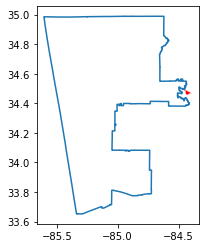

In [64]:
ax = ga_cong_districts[ga_cong_districts["HOUSE_DISTRICT"] == "014"].boundary.plot()
jasper_prec = vest_ga_20[vest_ga_20["PRECINCT_N"] == 'JASPER']
jasper_prec.plot(ax = ax, color = "red")

In [65]:
ga_election.loc[ga_election["precinct"]=="Jasper", 'GCON14RGRE'] = 0

In [66]:
ga_election[ga_election["unique_ID"].str.contains("Jasper")][[i for i in list(ga_election.columns) if '14' in i]]

mod_choice,GCON14DAUS,GCON14RGRE
2221,0.0,0.0


### Deal with any precincts that split districts

#### Try a  unique ID

In [67]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_N"]

#### Check whether there are duplicate IDs

In [68]:
ser_1 = ga_election["unique_ID"].value_counts(dropna=False)
print(ser_1[ser_1 >1])

ser_2 = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser_2[ser_2 >1])

Series([], Name: unique_ID, dtype: int64)
NaN                        7
051-ELI WHITNEY COMPLEX    2
Name: unique_ID, dtype: int64


In [69]:
#Look into duplicate IDs - ELI WHITNEY
display(vest_ga_20[vest_ga_20["unique_ID"]=="051-ELI WHITNEY COMPLEX"])

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,G20PSCDBLA,G20PSCLWIL,R21USSRPER,R21USSDOSS,R21USSRLOE,R21USSDWAR,R21PSCRMCD,R21PSCDBLA,geometry,unique_ID
2259,0513-15C,0513-15C,3-15C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,278,361,...,325,15,281,329,282,329,284,318,"POLYGON ((-81.02948 32.06200, -81.03000 32.060...",051-ELI WHITNEY COMPLEX
2261,0512-06C,0512-06C,2-06C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,65,335,...,301,19,52,312,53,311,54,300,"POLYGON ((-81.05333 32.07291, -81.05336 32.072...",051-ELI WHITNEY COMPLEX


In [70]:
#Assign new unique IDs, adding in PRECINCT_I to differentiate
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

In [71]:
#For the remaining NA unique_IDs, use the 'DISTRICT' value
vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']

In [72]:
#Create a dictionary of ID changes to match VEST
source_vest_id_changes_dict = {'051-1-17C ISLANDS CHRISTIAN CHURCH': '051-ISLANDS CHRISTIAN CHURCH', '051-7-14C COASTAL CATHEDRAL': '051-COASTAL CATHEDRAL', '051-7-07C ROTHWELL BAPTIST CHURCH': '051-ROTHWELL BAPTIST CHURCH', '051-4-07C WILMINGTON ISLAND UMC': '051-WILMINGTON ISLAND UMC', '051-4-08C WILMINGTON ISLAND PRES CHURCH': '051-WILMINGTON ISLAND PRES CHURCH', '051-1-16C FERGUSON AVE BAPTIST': '051-FERGUSON AVE BAPTIST', '051-7-11C SEVENTH DAY ADV CHURCH': '051-SEVENTH DAY ADV CHURCH', '051-7-16C POOLER RECREATION CENTER GYMNASIUM': '051-POOLER REC CENTER GYM', '051-7-08C BLOOMINGDALE COMM CTR': '051-BLOOMINGDALE COMM CTR', '051-4-13C SKIDAWAY ISLAND PRES CHURCH': '051-SKIDAWAY ISLAND PRES CHURCH', '051-6-10C STATION 3': '051-GEORGETOWN ELEMENTARY', '051-4-12C ST PETERS EPISCOPAL': '051-ST PETERS EPISCOPAL', '051-7-13C SOUTHSIDE FIRE TRNG CTR': '051-SOUTHSIDE FIRE TRNG CTR', '051-4-06C FIRST BAPTIST OF THE ISLAND': '051-FIRST BAPTIST OF THE ISLAND', '051-4-04C LIGHTHOUSE BAPTIST CHURCH': '051-LIGHTHOUSE BAPTIST CHURCH', '051-4-05C ST FRANCIS EPISCOPAL CHURCH': '051-ST FRANCIS EPISCOPAL CHURCH', '051-1-12C ISLE OF HOPE BAPTIST': '051-ISLE OF HOPE BAPTIST', '051-4-02C FRANK MURRAY COMM CENTER': '051-FRANK MURRAY COMM CENTER', '051-7-06C POOLER CITY HALL': '051-POOLER CITY HALL', '051-8-16C ROYAL CINEMAS AND IMAX': '051-ROYAL CINEMAS AND IMAX', '051-6-02C WINDSOR FOREST BAPTIST': '051-WINDSOR FOREST BAPTIST', '051-6-11C BAMBOO FARMS': '051-BAMBOO FARMS', '051-4-15C SKIDAWAY ISLAND STATE PARK': '051-SKIDAWAY ISLAND STATE PARK', '051-6-09C TRINITY LUTHERAN CHURCH': '051-TRINITY LUTHERAN CHURCH', '051-1-01C FIRST PRESBYTERIAN CHURCH': '051-FIRST PRESBYTERIAN CHURCH', '051-4-14C SKIDAWAY ISLAND BAPTIST': '051-SKIDAWAY ISLAND BAPTIST', '051-7-12C POOLER CHURCH': '051-POOLER CHURCH', '051-7-10C PROGRESSIVE REC CENTER': '051-PROGRESSIVE REC CENTER', '051-1-06C CENTRAL CHURCH OF CHRIST': '051-CENTRAL CHURCH OF CHRIST', '051-1-14C COMPASSION CHRISTIAN CHURCH': '051-COMPASSION CHRISTIAN CHURCH', '051-6-03C CRUSADER COMM CENTER': '051-CRUSADER COMM CENTER', '051-4-11C TYBEE ISLAND SCHOOL CAFE': '051-TYBEE ISLAND SCHOOL CAFE', '051-7-09C SAVANNAH HOLY C OF G': '051-SAVANNAH HOLY C OF G', '051-4-10C GUARD HOUSE COMM CTR': '051-GUARD HOUSE COMM CTR', '051-1-08C GRACE UNITED METHODIST CHURCH': '051-GRACE UNITED METHODIST CHURCH', '051-1-10C ST THOMAS EPISCOPAL CHURCH': '051-ST THOMAS EPISCOPAL CHURCH', '051-1-05C JEA BUILDING': '051-JEA BUILDING', '051-1-13C THE SANCTUARY': '051-THE SANCTUARY', '051-7-15C RICE CREEK SCHOOL': '051-RICE CREEK SCHOOL', '051-3-12C THUNDERBOLT MUNI COMPLEX': '051-THUNDERBOLT MUNI COMPLEX', '051-3-13C NEW COV 7 DAY ADV CH': '051-NEW COV 7 DAY ADV CH', '051-7-03C PB EDWARDS GYM': '051-PB EDWARDS GYM', '051-7-01C GARDEN CITY SENIOR CTR': '051-GARDEN CITY SENIOR CTR', '051-6-06C THE LIGHT CHURCH': '051-THE LIGHT CHURCH', '051-7-04C LAKE SHORE COMM CTR': '051-LAKE SHORE COMM CTR', '051-6-05C WINDSOR HALL': '051-WINDSOR HALL', '051-3-02C TEMPLE MICKVE ISRAEL': '051-TEMPLE MICKVE ISRAEL', '051-6-01C WHITE BLUFF PRESBYTERIAN': '051-WHITE BLUFF PRESBYTERIAN', '051-5-11C LARGO-TIBET ELEMENTARY': '051-LARGO-TIBET ELEMENTARY', '051-3-14C OGLETHORPE CHARTER ACADEMY': '051-OGLETHORPE CHARTER ACADEMY', '051-6-08C CHRIST MEMORIAL BAPTIST CHURCH': '051-CHRIST MEMORIAL BAPTIST CHURCH', '051-7-05C WOODLAWN BAPTIST CHURCH': '051-WOODLAWN BAPTIST CHURCH', '051-5-08C SAVANNAH PRIMITIVE BC': '051-SAVANNAH PRIMITIVE BC', '051-8-03C SILK HOPE BAPTIST CHURCH': '051-SILK HOPE BAPTIST CHURCH', '051-3-05C ALDERSGATE YOUTH CENTER': '051-ALDERSGATE YOUTH CENTER', '051-3-09C COKESBURY METHODIST': '051-COKESBURY METHODIST', '051-3-15C ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 3-15C', '051-8-13C SAVANNAH CHRISTIAN': '051-SAVANNAH CHRISTIAN', '051-5-07C STATION 1': '051-ELKS LODGE', '051-2-09C SALVATION ARMY': '051-SALVATION ARMY', '051-3-10C BIBLE BAPTIST CHURCH': '051-BIBLE BAPTIST CHURCH', '051-2-07C CHRIST COMMUNITY CHURCH': '051-CHRIST COMMUNITY CHURCH', '051-3-08C JENKINS HIGH SCHOOL': '051-JENKINS HIGH SCHOOL', '051-5-06C SEED CHURCH': '051-SEED CHURCH', '051-1-09C IMMANUEL BAPTIST CHURCH': '051-IMMANUEL BAPTIST CHURCH', '051-8-02C HELLENIC CENTER': '051-HELLENIC CENTER', '051-2-11C STILLWELL TOWERS': '051-STILLWELL TOWERS', '051-3-11C SOUTHSIDE BAPTIST CHURCH': '051-SOUTHSIDE BAPTIST CHURCH', '051-2-02C BLACKSHEAR COMMUNITY CENTER': '051-BLACKSHEAR COMMUNITY CENTER', '051-5-01C BARTLETT MIDDLE SCHOOL': '051-BARTLETT MIDDLE SCHOOL', '051-2-05C HOLY SPIRIT LUTHERAN CHURCH': '051-HOLY SPIRIT LUTHERAN CHURCH', '051-2-04C FELLOWSHIP OF LOVE CHURCH': '051-FELLOWSHIP OF LOVE CHURCH', '051-2-12C WILLIAMS COURT APTS': '051-WILLIAMS COURT APTS', '051-3-01C OLD COURTHOUSE': '051-OLD COURTHOUSE', '051-2-03C W W LAW CENTER': '051-W W LAW CENTER', '051-8-12C BEACH HIGH SCHOOL': '051-BEACH HIGH SCHOOL', '051-5-10C TATUMVILLE COMMUNITY CENTER': '051-TATUMVILLE COMMUNITY CENTER', '051-8-15C GARDEN CITY REC CENTER': '051-GARDEN CITY REC CENTER', '051-2-06C ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 2-06C', '051-3-03C SAVANNAH HIGH SCHOOL': '051-SAVANNAH HIGH SCHOOL', '051-8-01C CIVIC CENTER': '051-CIVIC CENTER', '051-3-04C FIRST AFRICAN BAPTIST CHURCH': '051-FIRST AFRICAN BAPTIST CHURCH', '051-5-05C LIBERTY CITY COMM CTR': '051-LIBERTY CITY COMM CTR', '051-5-02C SENIOR CITIZENS CENTER': '051-SENIOR CITIZENS CENTER', '051-8-08C RESUR OF OUR LORD CHURCH': '051-RESURRECTION OF OUR LORD CHURCH', '051-8-05C W BROAD ST YMCA': '051-W BROAD ST YMCA', '051-8-06C TOMPKINS REC CENTER': '051-TOMPKINS REC CENTER', '051-8-09C MOSES JACKSON CENTER': '051-MOSES JACKSON CENTER', '051-5-03C BUTLER PRESBYTERIAN CHURCH': '051-BUTLER PRESBYTERIAN CHURCH', '051-8-11C BUTLER ELEMENTARY': '051-BUTLER ELEMENTARY', '051-8-07C WOODVILLE-TOMPKINS TI': '051-WOODVILLE-TOMPKINS TI', '051-8-10C CARVER HEIGHTS COMM CTR': '051-CARVER HEIGHTS COMM CTR', '053-ACTIVITY CENTER': '053-ACTIVITY CENTER (Includes FTBEN 1-3)', '067-POWDERS SPRINGS 1A': '067-POWDER SPRINGS 1A', '067-POWDERS SPRINGS 2A': '067-POWDER SPRINGS 2A', '067-POWDERS SPRINGS 3A': '067-POWDER SPRINGS 3A', '171-CHAPPELL MILL V FD': '171-CHAPPELL MILL VFD', '275-LITTLE OCHLOCKNEE BAPTIST CHURCH': '275-LITTLE OCHLOCKNEE', '299-100': '299-District 1', '299-200A': '299-District 2A', '299-200B': '299-District 2B', '299-300': '299-1231-150B', '299-304': '299-1231-150C', '299-400': '299-1231-151', '299-404': '299-Beach-Bickley', '299-405': '299-Haywood', '299-406': '299-Jamestown', '299-407': '299-Manor', '299-408': '299-Millwood', '299-409': '299-Waresboro', '317-TIGNAL SCH LUNCH RM': '317-TIGNALL SCH LUNCH RM'}

#Apply the changes
ga_election["unique_ID"] = ga_election["unique_ID"].map(source_vest_id_changes_dict).fillna(ga_election["unique_ID"])

In [73]:
#Attempt to join
join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]

both          2655
right_only      23
left_only        0
Name: _merge, dtype: int64


In [74]:
races = [i for i in list(ga_election.columns) if "GCON" in i]

In [75]:
for val in races:
    join_attempt_1[val] = join_attempt_1[val].fillna(0)
    join_attempt_1[val] = join_attempt_1[val].astype(int)

In [76]:
#Confirm that the unjoined precincts contain zero-votes
empty_precincts = []
for index, row in right_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["DISTRICT"])
print(len(empty_precincts))  

23


## Look into split precincts

In [77]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "GSLP":
        level = "SL"
        dist = "004"
    elif column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "GCO":
        level = "CON"
        dist = column_name[4:6]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]

precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in join_attempt_1.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["unique_ID"]]=is_split
    precinct_mapping_dict[row["unique_ID"]]=precinct_list

In [78]:
split_precincts_list

{'021-HAZZARD 4': {'CON': ['02', '08']},
 '021-HOWARD 1': {'CON': ['02', '08']},
 '067-CHATTAHOOCHEE 01': {'CON': ['06', '11']},
 '067-EAST PIEDMONT 01': {'CON': ['06', '11']},
 '067-FAIR OAKS 04': {'CON': ['11', '13']},
 '067-MARIETTA 5A': {'CON': ['06', '11']},
 '067-MARIETTA 6A': {'CON': ['06', '11']},
 '067-MARIETTA 7A': {'CON': ['06', '11']},
 '067-PALMER 01': {'CON': ['06', '11']},
 '067-POWERS FERRY 01': {'CON': ['06', '11']},
 '067-SMYRNA 3A': {'CON': ['11', '13']},
 '067-SMYRNA 4A': {'CON': ['11', '13']},
 '067-SMYRNA 6A': {'CON': ['11', '13']},
 '067-SMYRNA 7A': {'CON': ['11', '13']},
 '073-HARLEM BRANCH LIBRARY': {'CON': ['10', '12']},
 '073-HARLEM SENIOR CENTER': {'CON': ['10', '12']},
 '073-KIOKEE BAPTIST CHURCH': {'CON': ['10', '12']},
 '089-AVONDALE HIGH': {'CON': ['04', '05']},
 '089-GLENNWOOD': {'CON': ['04', '05']},
 '089-WADSWORTH': {'CON': ['04', '05']},
 '089-WINNONA PARK': {'CON': ['04', '05']},
 '103-1B': {'CON': ['01', '12']},
 '103-4B': {'CON': ['01', '12']},
 

### Perform the Precinct Splits

In [79]:
ga_cong_districts["HOUSE_DISTRICT"] = ga_cong_districts["HOUSE_DISTRICT"].str[1:3]
join_attempt_1["CONG_DIST"] = 0
join_attempt_1 = gp.GeoDataFrame(join_attempt_1, crs = vest_ga_20.crs)

In [80]:
## Define the "CONG_DIST" column

In [81]:
def return_cd(row):
    for val in races:
        if row[val] != 0:
            return val[4:6]

In [82]:
join_attempt_1["CONG_DIST"] = join_attempt_1.apply(lambda row: return_cd(row), axis = 1)

In [83]:
for val in join_attempt_1["unique_ID"]:
    cd_list = []
    if val in split_precincts_list.keys():
        print(val)
        join_attempt_1 = helper_functions.district_splits_mod(split_precincts_list[val],"CONG",val, join_attempt_1, ga_cong_districts, "unique_ID", "HOUSE_DISTRICT", races, "CONG_DIST")

021-HAZZARD 4
021-HOWARD 1
067-CHATTAHOOCHEE 01
067-EAST PIEDMONT 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-FAIR OAKS 04
067-MARIETTA 5A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 6A
067-MARIETTA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-PALMER 01
067-POWERS FERRY 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 3A
067-SMYRNA 4A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 6A
067-SMYRNA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


073-HARLEM BRANCH LIBRARY
073-HARLEM SENIOR CENTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


073-KIOKEE BAPTIST CHURCH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-AVONDALE HIGH
089-GLENNWOOD
089-WADSWORTH
089-WINNONA PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


103-1B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


103-4B
113-DOGWOOD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-SANDY CREEK
117-03 BROWNS BRIDGE
117-16 OTWELL
117-37 SAWNEE
135-CATES D
151-UNITY GROVE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-NAYLOR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-EPWORTH UMC
215-ST PAUL/CLUBVIEW


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-ALCOVY
217-ROCKY PLAINS
227-TATE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-NORTHGATE ASSEMBLY AND TRINITY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/general/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


In [84]:
join_attempt_1.rename(columns = {'unique_ID':"UNIQUE_ID", 'county_fips':'COUNTYFP'}, inplace = True)

In [85]:
join_attempt_1[join_attempt_1["CONG_DIST"].isna()]

,UNIQUE_ID,county,COUNTYFP,precinct,GCON01DGRI,GCON01RCAR,GCON02DBIS,GCON02RCOL,GCON03DALM,GCON03RFER,...,G20PSCLWIL,R21USSRPER,R21USSDOSS,R21USSRLOE,R21USSDWAR,R21PSCRMCD,R21PSCDBLA,geometry,_merge,CONG_DIST
1350,121-CP084,Fulton,121,CP084,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"POLYGON ((-84.49300 33.62276, -84.49299 33.622...",both,None
1449,121-SC08H,Fulton,121,SC08H,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"POLYGON ((-84.52567 33.60766, -84.52566 33.607...",both,None
1518,121-UC01D,Fulton,121,UC01D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((-84.53190 33.61943, -84.53180 ...",both,None
2618,121-AP01E,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"POLYGON ((-84.29795 34.03893, -84.29797 34.037...",right_only,None
2619,121-UC033,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"MULTIPOLYGON (((-84.50565 33.58889, -84.50668 ...",right_only,None
2620,121-03P1B,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"POLYGON ((-84.40813 33.77318, -84.40764 33.773...",right_only,None
2621,121-AP12D,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"POLYGON ((-84.25836 34.09181, -84.25818 34.091...",right_only,None
2622,121-SC29B,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"POLYGON ((-84.51576 33.58520, -84.51580 33.585...",right_only,None
2623,121-CP06B,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"POLYGON ((-84.46700 33.62007, -84.47102 33.620...",right_only,None
2624,121-CP053,NaN,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"POLYGON ((-84.48197 33.62309, -84.48200 33.623...",right_only,None


In [86]:
join_attempt_1 = join_attempt_1[["UNIQUE_ID", 'COUNTYFP','DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2','CONG_DIST']+races+["geometry"]]

## Check Added Column Totals

In the 'statewide-county-totals-check-erj' we created a cleaned csv of the county totals from the GA sos website

In [87]:
official_county_totals = pd.read_csv("./cleaned_official_county_totals.csv")

In [88]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", join_attempt_1, "ERJ Totals", races)

***Statewide Totals Check***
GCON01DGRI is equal 	 both dataframes 135238
GCON01RCAR is equal 	 both dataframes 189457
GCON02DBIS is equal 	 both dataframes 161397
GCON02RCOL is equal 	 both dataframes 111620
GCON03DALM is equal 	 both dataframes 129792
GCON03RFER is equal 	 both dataframes 241526
GCON04DJOH is equal 	 both dataframes 278906
GCON04REZA is equal 	 both dataframes 69393
GCON05DWIL is equal 	 both dataframes 301857
GCON05RSTA is equal 	 both dataframes 52646
GCON06DMCB is equal 	 both dataframes 216775
GCON06RHAN is equal 	 both dataframes 180329
GCON07DBOU is equal 	 both dataframes 190900
GCON07RMCC is equal 	 both dataframes 180564
GCON08DHOL is equal 	 both dataframes 109264
GCON08RSCO is equal 	 both dataframes 198701
GCON09DPAN is equal 	 both dataframes 79797
GCON09RCLY is equal 	 both dataframes 292750
GCON10DJOH is equal 	 both dataframes 142636
GCON10RHIC is equal 	 both dataframes 235810
GCON11DBAR is equal 	 both dataframes 160623
GCON11RLOU is equal 	 both da

## Check Column Totals - County Level

In [89]:
official_county_totals["CTYNAME"] = official_county_totals["county"].str.upper()

In [90]:
helper_functions.county_totals_check(official_county_totals, "Official Totals", join_attempt_1, "ERJ Totals", races, "CTYNAME")

***Countywide Totals Check***

GCON01DGRI is equal across all counties
GCON01RCAR is equal across all counties
GCON02DBIS is equal across all counties
GCON02RCOL is equal across all counties
GCON03DALM is equal across all counties
GCON03RFER is equal across all counties
GCON04DJOH is equal across all counties
GCON04REZA is equal across all counties
GCON05DWIL is equal across all counties
GCON05RSTA is equal across all counties
GCON06DMCB is equal across all counties
GCON06RHAN is equal across all counties
GCON07DBOU is equal across all counties
GCON07RMCC is equal across all counties
GCON08DHOL is equal across all counties
GCON08RSCO is equal across all counties
GCON09DPAN is equal across all counties
GCON09RCLY is equal across all counties
GCON10DJOH is equal across all counties
GCON10RHIC is equal across all counties
GCON11DBAR is equal across all counties
GCON11RLOU is equal across all counties
GCON12DJOH is equal across all counties
GCON12RALL is equal across all counties
GCON13DSC

## Check District Assignments

In [91]:
## Intersect the District with GA_CONG to fill in the n/a values

In [92]:
na_values = join_attempt_1[join_attempt_1["CONG_DIST"].isna()]
others = join_attempt_1[~(join_attempt_1["CONG_DIST"].isna())]

In [93]:
print(join_attempt_1.shape)
print(others.shape)
print(na_values.shape)

(2716, 40)
(2690, 40)
(26, 40)


In [94]:
intersected = gp.overlay(ga_cong_districts, na_values, how = "intersection")

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_81964/208730160.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersected = gp.overlay(ga_cong_districts, na_values, how = "intersection")


In [95]:
# Create a dictionary to map

intersected['area'] = intersected.area

na_assignment_dict = {}

for val in intersected["UNIQUE_ID"].unique():

    assignment = intersected.loc[intersected["UNIQUE_ID"] == val].nlargest(1, 'area')["HOUSE_DISTRICT"].values[0]
    na_assignment_dict[val] = assignment

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_81964/4269042095.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersected['area'] = intersected.area


In [96]:
join_attempt_1["CONG_DIST"] = join_attempt_1["UNIQUE_ID"].map(na_assignment_dict).fillna(join_attempt_1["CONG_DIST"])

In [97]:
assigned_districts = join_attempt_1.dissolve(["CONG_DIST"])
assigned_districts.reset_index(drop=False,inplace=True)

In [98]:
ga_cong_districts["CONG_DIST"] = ga_cong_districts["HOUSE_DISTRICT"]

Checking 14 precincts for differences of greater than 0.1 km^2

1) For 05 difference in area is 0.6570271682469174
2) For 06 difference in area is 0.23580988567380462
3) For 11 difference in area is 0.2262837673862089
4) For 13 difference in area is 0.6973618725988782

Scroll down to see plots of any differences

Of the 14 precincts:

0 precincts w/ a difference of 0 km^2
10 precincts w/ a difference between 0 and .1 km^2
2 precincts w/ a difference between .1 and .5 km^2
2 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


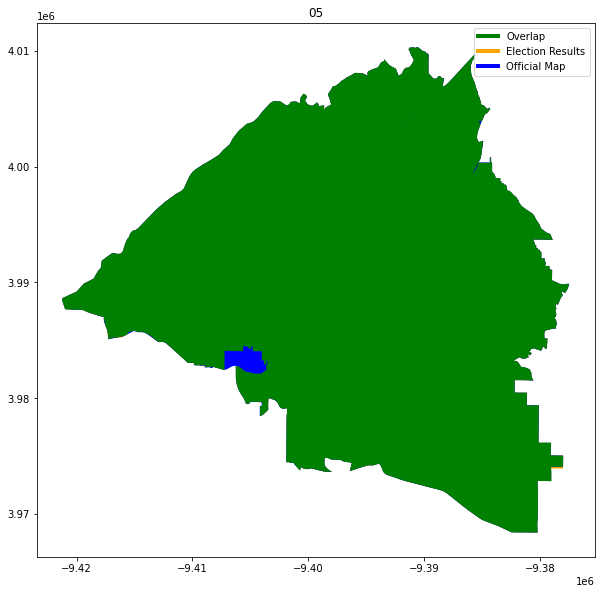

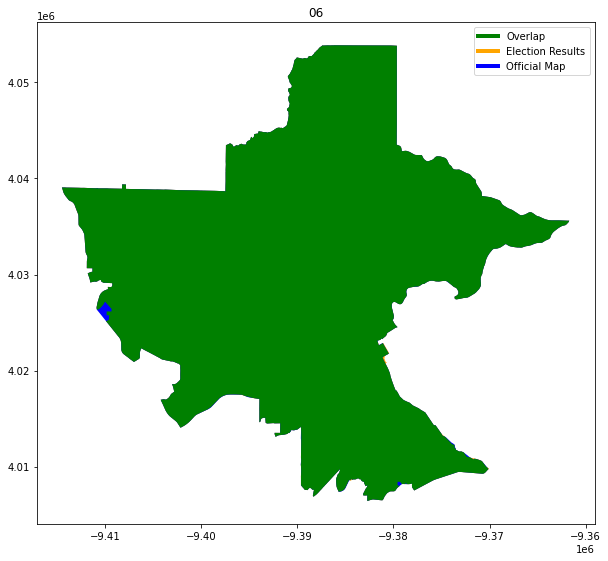

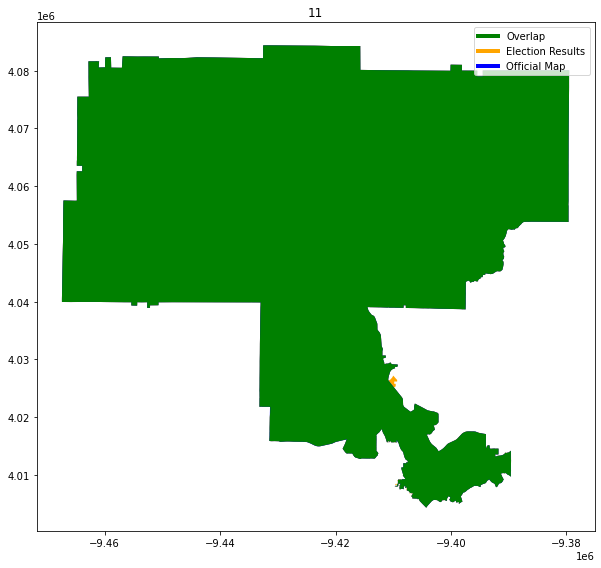

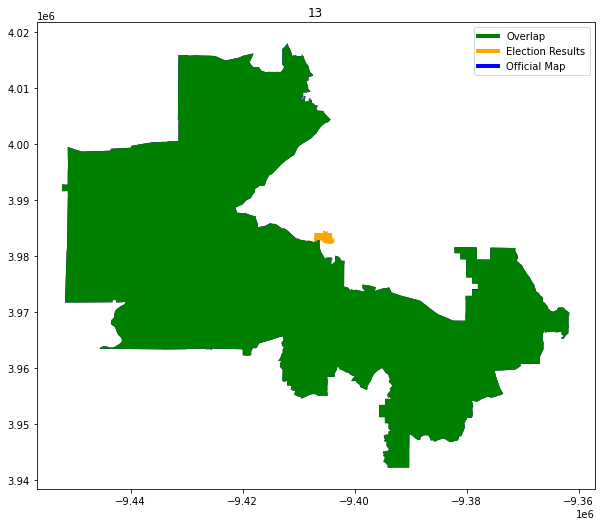

In [99]:
helper_functions.compare_geometries(assigned_districts, ga_cong_districts ,"Election Results", "Official Map", "CONG_DIST",area_threshold=.1)

## Prepare to Export

In [101]:
join_attempt_1.to_file("./ga_gen_20_prec/ga_gen_20_cong_prec.shp")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
